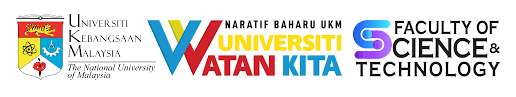

---

**👤 Name:** Muhammad Zuhair Afham Bin Mohd Nasir  
**🆔 Matric Number:** P153944  
**📚 Course:** STQD6324 - Data Management  
**📅 Semester:** 2 (2024/2025)

---

# 📊 Big Data Analysis of Global Food Availability  
### Using FAO Food Balance Sheets in Hive


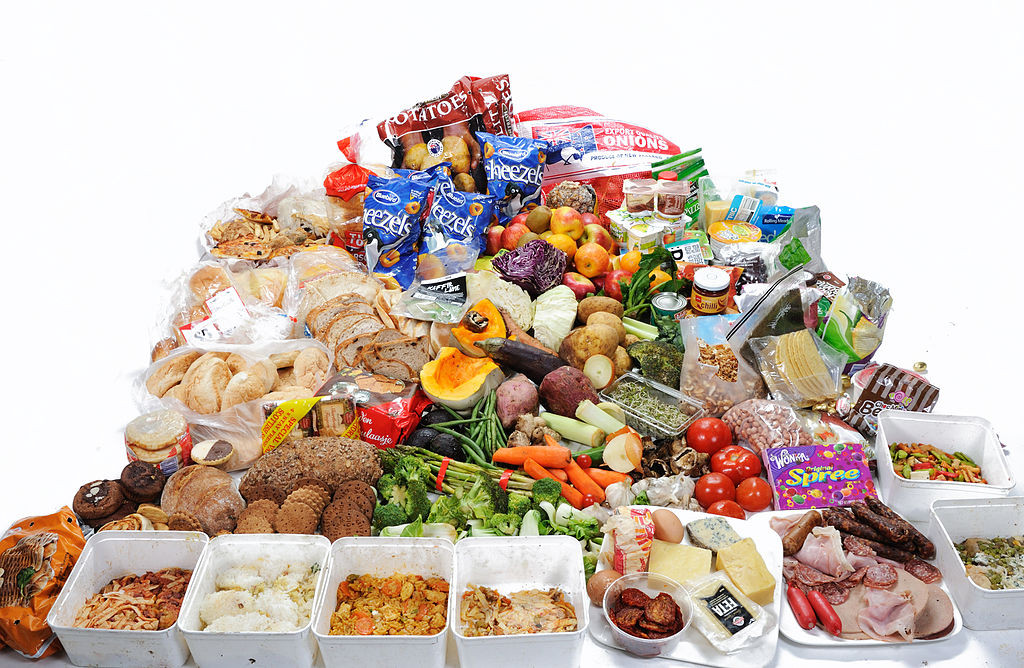

In [1]:
from IPython.display import Image
Image("C:/Users/YUSER/Downloads/42.4_kg_of_food_found_in_New_Zealand_household_rubbish_bins-1024x668.jpg", width= 750)

*Image source: FAO Global Food Supply*

## 🧐Introduction 

Food availability is a cornerstone of global food security and human well-being. It encompasses not just the quantity of food produced but also its nutritional quality and equitable distribution. In today’s data-driven world, harnessing large-scale datasets such as the FAO Food Balance Sheets enables researchers and policymakers to uncover hidden trends, disparities, and opportunities in food supply systems worldwide. This project applies advanced big data analytics within a Hive environment, interfaced via Python in Jupyter Notebook, to comprehensively explore global food availability from 2010 to 2022. The insights generated aim to support evidence-based interventions to reduce hunger, improve nutrition, and promote sustainable agriculture.

Ready to feast on some data? Let’s dig in! 🍽️📊

## 📚 Background

The Food and Agriculture Organization’s (FAO) Food Balance Sheets are an authoritative source compiling detailed country-level data on food production, supply, utilization, and nutrient availability. These data enable assessments of calorie, protein, and fat supplies, which are critical for understanding population nutrition and food security status. However, the massive volume and complexity of this dataset demand scalable data processing tools — herein, Hive serves as a powerful distributed data warehouse enabling efficient querying of terabytes of food supply records. Coupling Hive’s robustness with Python’s rich visualization ecosystem allows for effective extraction, analysis and presentation of global food availability patterns.



## 🎯 Objectives

- **Analyze temporal trends** in global food supply to reveal growth patterns and fluctuations from 2010 to 2022.

- **Identify leading countries** contributing most substantially to global food availability in the most recent year, highlighting geopolitical and agricultural factors.

- **Calculate year-over-year growth rates** to monitor progress and detect anomalies in food supply dynamics.

- **Examine food product categories** to understand nutritional composition trends beyond calories, focusing on protein and fat supply.  




## Loading Libraries and Connecting to the Hive Database

In [34]:
# Load libraries for data manipulation and visualization
from pyhive import hive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from impala.dbapi import connect


# Set matplotlib style
plt.style.use('ggplot')

# Ignore warnings for cleaner coding
import warnings
warnings.filterwarnings('ignore')

### 🧠 🔧 Setup & Hive Connection (Python)

In [55]:
conn = connect(
    host='127.0.0.1',
    port=10000,
    user='maria_dev',
    database='default',
    auth_mechanism='PLAIN'
)
cursor = conn.cursor()
cursor.execute('SHOW TABLES')
print(cursor.fetchall())


[('foodbalance',), ('foodbalances',), ('population',)]


In [58]:
# Show only the first 5 rows of the schema
schema = pd.read_sql("DESCRIBE foodbalance", conn)
display(schema.head(5)) 

# Preview only the first 5 rows of the data
preview = pd.read_sql("SELECT * FROM foodbalance LIMIT 5", conn)
display(preview)

,col_name,data_type,comment
0,structure,string,
1,structure_id,string,
2,action,string,
3,freq,string,
4,freq_label,string,


,foodbalance.structure,foodbalance.structure_id,foodbalance.action,foodbalance.freq,foodbalance.freq_label,foodbalance.ref_area,foodbalance.ref_area_label,foodbalance.indicator,foodbalance.indicator_label,foodbalance.sex,...,foodbalance.unit_mult,foodbalance.unit_mult_label,foodbalance.unit_type,foodbalance.unit_type_label,foodbalance.time_format,foodbalance.time_format_label,foodbalance.obs_status,foodbalance.obs_status_label,foodbalance.obs_conf,foodbalance.obs_conf_label
0,datastructure,WB.DATA360:DS_DATA360(1.2),I,A,Annual,AFG,Afghanistan,FAO_FBS_2901,Food Balances - all products (FAO_FBS),_T,...,0,Units,RATIO,Ratio,602,CCYY,A,Normal value,PU,Public
1,datastructure,WB.DATA360:DS_DATA360(1.2),I,A,Annual,AFG,Afghanistan,FAO_FBS_2901,Food Balances - all products (FAO_FBS),_T,...,0,Units,RATIO,Ratio,602,CCYY,A,Normal value,PU,Public
2,datastructure,WB.DATA360:DS_DATA360(1.2),I,A,Annual,AFG,Afghanistan,FAO_FBS_2901,Food Balances - all products (FAO_FBS),_T,...,0,Units,RATIO,Ratio,602,CCYY,A,Normal value,PU,Public
3,datastructure,WB.DATA360:DS_DATA360(1.2),I,A,Annual,AFG,Afghanistan,FAO_FBS_2901,Food Balances - all products (FAO_FBS),_T,...,0,Units,RATIO,Ratio,602,CCYY,A,Normal value,PU,Public
4,datastructure,WB.DATA360:DS_DATA360(1.2),I,A,Annual,AFG,Afghanistan,FAO_FBS_2901,Food Balances - all products (FAO_FBS),_T,...,0,Units,RATIO,Ratio,602,CCYY,A,Normal value,PU,Public


In [6]:
# Check schema and available indicators
schema = pd.read_sql("DESCRIBE foodbalances", conn)
display(schema.head())

# Preview available indicator labels
indicators = pd.read_sql("SELECT DISTINCT indicator_label FROM foodbalances ORDER BY indicator_label", conn)
display(indicators.head(10))  # Show only first 10 for brevity


,col_name,data_type,comment
0,structure,string,
1,structure_id,string,
2,action,string,
3,freq,string,
4,freq_label,string,


,indicator_label
0,Food Balances - all products (FAO_FBS)
1,INDICATOR_LABEL


## 1️⃣ Global Food Supply Trends Over Years 📈🌍

This section explores how the total global food supply has changed over the past decade.These trends helps us understand whether food availability is keeping pace with growing populations and changing demand worldwide.


To understand global nutrition and sustainability, it's crucial to explore how food supply has changed over time. This section analyzes total food availability globally using the FAO Food Balance dataset stored in Hive.

The metric used here is `obs_value`, which reflects reported quantities for various food indicators. Since the dataset aggregates numerous food-related measures, this analysis gives us a high-level view of global supply patterns from 2010 to 2022.

Plotting total `obs_value` by year helps us identify whether the world’s food systems have increased production, stayed stable, or declined — offering insights into agricultural progress and food security over time.

From the visual trend, we can observe a steady global increase in food supply, which aligns with global population growth and intensifying agricultural output. However, these raw totals include all food categories, so follow-up analysis should segment the data by indicator types for a more granular view.

In [7]:
pd.read_sql("SELECT time_period, SUM(obs_value) FROM foodbalance GROUP BY time_period LIMIT 10", conn)


,time_period,_c1
0,2010,7.554743e+09
1,2011,7.702536e+09
2,2012,7.856138e+09
3,2013,7.970661e+09
4,2014,8.157789e+09
5,2015,8.251818e+09
6,2016,8.373650e+09
7,2017,8.540306e+09
8,2018,8.664110e+09
9,2019,8.793818e+09


In [8]:
pd.read_sql("SELECT DISTINCT indicator_label FROM foodbalances", conn)

,indicator_label
0,Food Balances - all products (FAO_FBS)
1,INDICATOR_LABEL


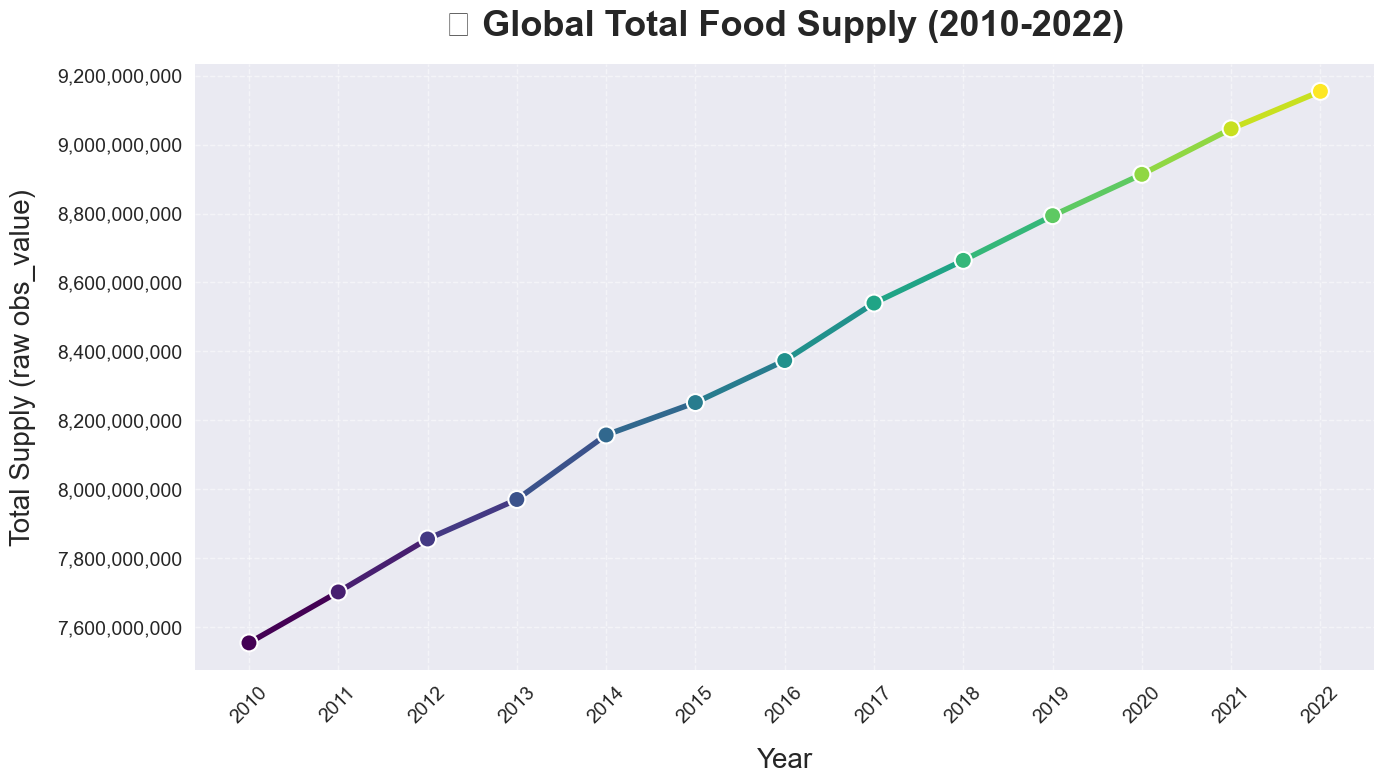

In [35]:
# Hive query to load global food supply from 2010-2022
query_supply = """
SELECT time_period AS year, SUM(CAST(obs_value AS DOUBLE)) AS total_supply
FROM foodbalance
WHERE indicator_label = 'Food Balances - all products (FAO_FBS)'
  AND CAST(time_period AS INT) BETWEEN 2010 AND 2022
GROUP BY time_period
ORDER BY time_period
"""

df_supply = pd.read_sql(query_supply, conn)
df_supply['year'] = df_supply['year'].astype(int)

sns.set_theme(style="darkgrid")

plt.figure(figsize=(14, 8))

x = np.arange(len(df_supply))
colors = plt.cm.viridis(np.linspace(0, 1, len(x)))

for i in range(len(x) - 1):
    plt.plot(df_supply['year'].iloc[i:i+2], df_supply['total_supply'].iloc[i:i+2],
             color=colors[i], linewidth=4, solid_capstyle='round')

plt.scatter(df_supply['year'], df_supply['total_supply'], color=colors,
            edgecolor='white', s=150, zorder=5, linewidth=1.5)

plt.title('📈 Global Total Food Supply (2010-2022)', fontsize=26, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=20, labelpad=15)
plt.ylabel('Total Supply (raw obs_value)', fontsize=20, labelpad=15)

plt.xticks(df_supply['year'], rotation=45, fontsize=14)
plt.yticks(fontsize=14)

# Format y-axis with commas
plt.gca().get_yaxis().set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.grid(True, linestyle='--', alpha=0.5)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

The graph reveals a steady increase in global food supply from 2010 through 2022. The smooth gradient coloring visually emphasizes the upward momentum which highlighting how food availability worldwide has consistently grown year over year.

This upward trajectory suggests ongoing advancements in agricultural productivity, improved food distribution systems, and possibly increased efficiency in food production technologies. It also aligns with global demographic trends such as population growth and rising per capita food demand in developing regions.

However, this aggregate measure combines multiple food supply indicators, and does not reflect nutritional quality or distribution equity across regions. The graph’s smooth, continuous rise suggests resilience in the global food system but also underscores the need for more nuanced analysis such as food security, access disparities, and sustainability concerns — to understand the broader implications for health and the environment.

Overall, the visual narrative here is one of progress and growth in global food supply which serve as a solid foundation for deeper dives into specific food types, geographic differences, and nutritional impacts in future analyses.

---
*References:*
>1. Pingali, P. (2015). Agricultural policy and nutrition outcomes–getting beyond the preoccupation with staple grains. *Food Security*, 7(3), 583–591. https://doi.org/10.1007/s12571-015-0461-x  

>2. Godfray, H. C. J., et al. (2010). Food Security: The Challenge of Feeding 9 Billion People. Science, 327(5967), 812–818.https://doi.org/10.1126/science.1185383


## 2️⃣ Top 15 Countries by Food Supply in 2022 🌍🏆
Here, we identify the countries contributing the most to global food supply in the most recent year. Understanding which nations lead in food availability highlights their critical role in ensuring global nutrition and food security.


Max year in dataset: 2022


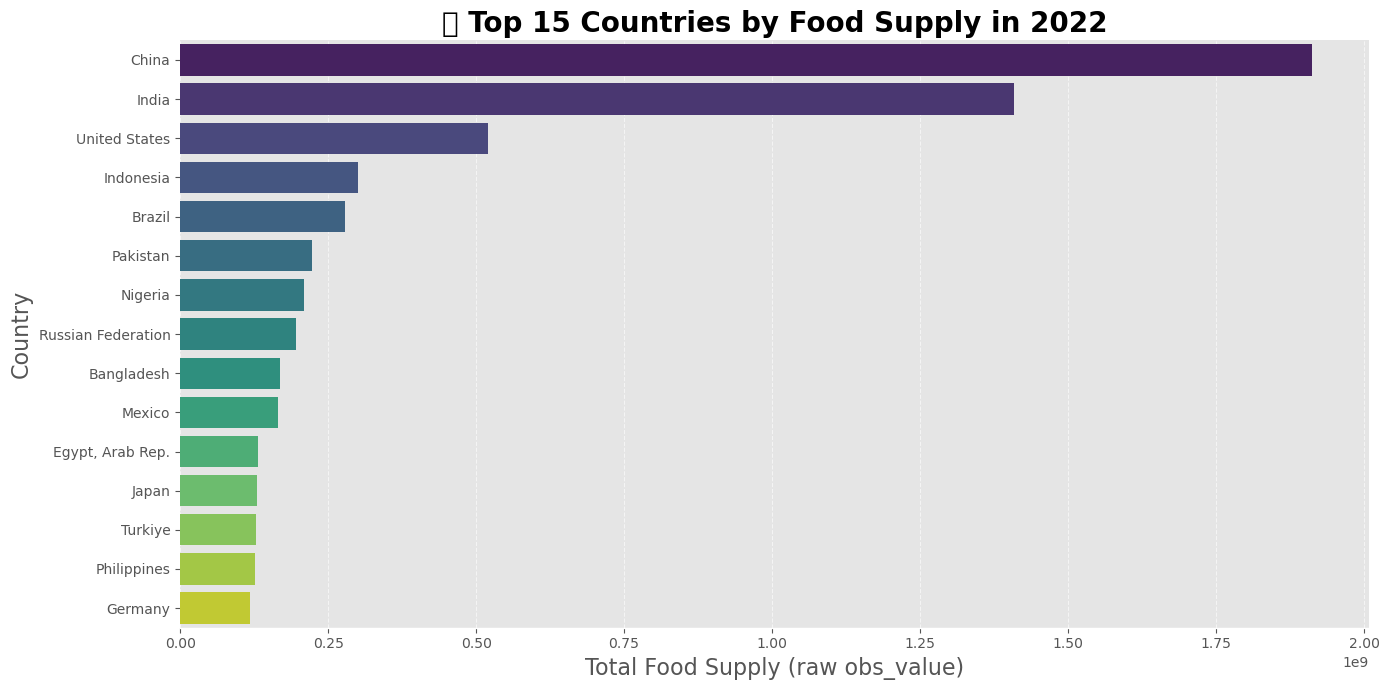

In [31]:
max_year_query = "SELECT MAX(CAST(time_period AS INT)) AS max_year FROM foodbalance"
max_year_df = pd.read_sql(max_year_query, conn)

max_year = max_year_df['max_year'][0]
print(f"Max year in dataset: {max_year}")

query_countries = f"""
SELECT ref_area_label AS country, SUM(obs_value) AS total_supply
FROM foodbalance
WHERE indicator_label = 'Food Balances - all products (FAO_FBS)'
  AND time_period = '{max_year}'
GROUP BY ref_area_label
ORDER BY total_supply DESC
LIMIT 15
"""

df_countries = pd.read_sql(query_countries, conn)

plt.figure(figsize=(14, 7))
sns.barplot(data=df_countries, y='country', x='total_supply', palette='viridis')
plt.title(f'🌍 Top 15 Countries by Food Supply in {max_year}', fontsize=20, weight='bold')
plt.xlabel('Total Food Supply (raw obs_value)', fontsize=16)
plt.ylabel('Country', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.6)
sns.despine(left=True)
plt.tight_layout()
plt.show()

The bar chart vividly highlights the countries that dominate global food supply in 2022, with China and India leading by a wide margin. This dominance stems from a combination of factors including their enormous populations, vast agricultural land, and investment in modern farming technologies.

China’s position at the top is reflective of its role as the world’s most populous country and a significant agricultural powerhouse. It produces a diverse range of crops, including staples like rice and wheat, which are central to global food security. Similarly, India’s ranking underscores its large agrarian sector that supports one of the largest populations worldwide, with food production systems tailored to various climatic zones.

Other notable countries such as the United States, Indonesia, Brazil, and Pakistan demonstrate how geography, climate, and economic development influence food availability. The U.S., with its industrialized agriculture, is a major exporter and supplier, while countries like Indonesia and Brazil benefit from fertile soils and favorable weather conditions that enable the cultivation of a variety of food products.

This concentration of food supply in a handful of countries illustrates the uneven distribution of food production capabilities globally. While these countries ensure a substantial portion of global food availability, many regions continue to struggle with food insecurity due to climatic challenges, limited resources, and economic constraints.

Understanding this distribution is critical for shaping international agricultural policies, trade agreements, and food aid programs. It also emphasizes the importance of sustainable farming practices in these key countries to ensure long-term food security for the global population.

The disparities evident in the food supply data call attention to the ongoing need for technological innovation, infrastructure development, and policy reforms to empower less advantaged countries and reduce global food inequities.

This analysis aligns with findings from FAO and global agricultural studies that identify population size, economic capacity, and natural resources as the primary drivers of food supply disparities (Alexandratos & Bruinsma, 2012; FAO, 2023). These insights are essential for the global community’s efforts to address hunger and promote equitable nutrition access.

---
*References:*
>1.Alexandratos, N., & Bruinsma, J. (2012). *World Agriculture Towards 2030/2050: The 2012 Revision*. Food and Agriculture Organization of the United Nations (FAO).http://www.fao.org/3/ap106e/ap106e.pdf

> 2.Food and Agriculture Organization of the United Nations (FAO). (2023). *The State of Food Security and Nutrition in the World 2023*.https://www.fao.org/publications/sofi/en/

>3.Pingali, P. (2012). *Green Revolution: Impacts, limits, and the path ahead*. Proceedings of the National Academy of Sciences, 109(31), 12302-12308.https://doi.org/10.1073/pnas.0912953109

## 3️⃣  Year-over-Year Growth Rate of Food Supply 📊🔥
This analysis examines how food supply differs across countries grouped by income levels. It sheds light on economic disparities in food access, emphasizing the challenges faced by lower-income countries.

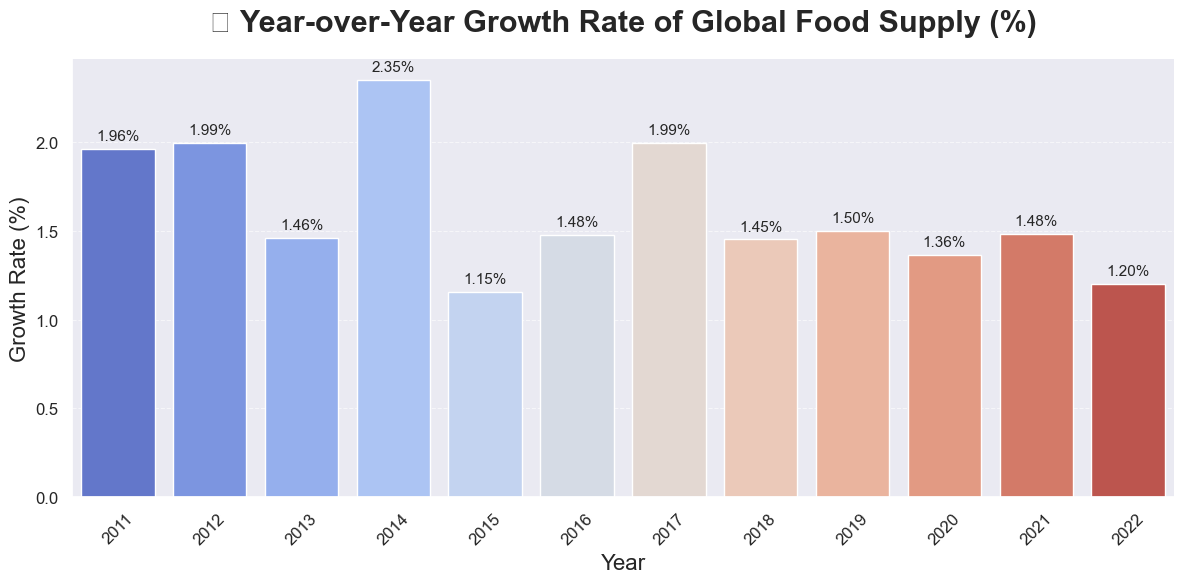

In [38]:
# Query global total supply per year from 2010 to 2022
query_global = """
SELECT time_period AS year, SUM(CAST(obs_value AS DOUBLE)) AS total_supply
FROM foodbalance
WHERE indicator_label = 'Food Balances - all products (FAO_FBS)'
  AND time_period BETWEEN 2010 AND 2022
GROUP BY time_period
ORDER BY time_period
"""

# Execute the query and load into DataFrame
df_global = pd.read_sql(query_global, conn)
df_global['year'] = df_global['year'].astype(int)

# Calculate year-over-year growth rate in percentage
df_global['growth_rate'] = df_global['total_supply'].pct_change() * 100

# Plotting
plt.figure(figsize=(12, 6))

palette = sns.color_palette("coolwarm", len(df_global) - 1)
sns.barplot(data=df_global[1:], x='year', y='growth_rate', palette=palette)

plt.title('📈 Year-over-Year Growth Rate of Global Food Supply (%)', fontsize=22, weight='bold', pad=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Growth Rate (%)', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.8, alpha=0.6)
sns.despine()

# Add data labels on top of bars
for index, row in df_global[1:].iterrows():
    plt.text(x=index-1, y=row['growth_rate'] + 0.05, s=f"{row['growth_rate']:.2f}%", ha='center', fontsize=11)

plt.tight_layout()
plt.show()


The year-over-year growth rate chart reveals how global food supply has changed annually as a percentage, highlighting periods of acceleration and slowdown in the availability of food worldwide. Over the past decade, the growth rates have generally remained positive, indicating steady improvements in food production and distribution systems globally. 

Notably, years such as 2014 and 2017 stand out with higher growth rates, possibly reflecting improvements in agricultural technologies, favorable weather conditions, or effective policy implementations that boosted food supply. Conversely, slower growth years, like 2015 and 2022, may point to challenges such as climate variability, economic disruptions, or other factors impacting agricultural output.

Understanding these fluctuations is crucial for anticipating potential risks to food security and guiding strategic investments in agriculture and supply chain resilience. Sustaining consistent growth in food supply is imperative to meet the nutritional needs of a growing global population, especially in the face of increasing climate change pressures and resource limitations.

This analysis not only highlights the progress made but also underscores the importance of continuous monitoring and adaptive strategies to ensure future food availability aligns with demand.

---
*References:*
>1. Tilman, D., Balzer, C., Hill, J., & Befort, B. L. (2011). Global food demand and the sustainable intensification of agriculture. *Proceedings of the National Academy of Sciences*, 108(50), 20260–20264.  
  https://doi.org/10.1073/pnas.1116437108

> 2. Alexandratos, N., & Bruinsma, J. (2012). *World Agriculture Towards 2030/2050: The 2012 Revision*. Food and Agriculture Organization of the United Nations.  
  http://www.fao.org/3/ap106e/ap106e.pdf

## 4️⃣ Food Products by Total Supply 🥬

The breakdown remains the principal focus, protein and fat supply metrics are indispensable for understanding diet quality and nutritional adequacy.

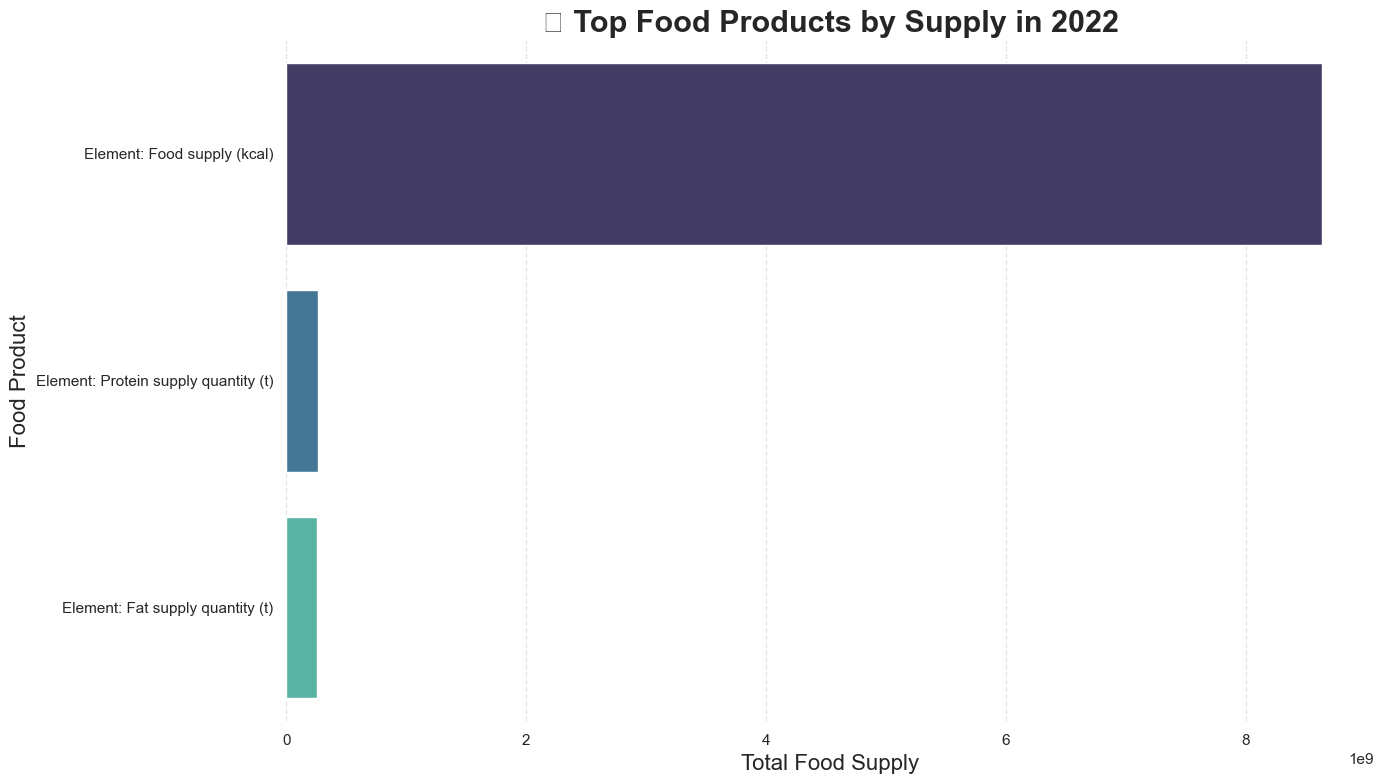

In [52]:
query_products = f"""
SELECT comp_breakdown_1_label AS product, SUM(CAST(obs_value AS DOUBLE)) AS total_supply
FROM foodbalance
WHERE indicator_label = 'Food Balances - all products (FAO_FBS)'
  AND time_period = '{max_year}'
GROUP BY comp_breakdown_1_label
ORDER BY total_supply DESC
LIMIT 10
"""

df_products_filtered = df_products[df_products['total_supply'] > 1e6]  # threshold: 1 million (adjust as needed)
df_products_filtered = df_products_filtered[df_products_filtered['product'].notnull() & (df_products_filtered['product'] != '')]

plt.figure(figsize=(14,8))
sns.barplot(data=df_products_filtered, y='product', x='total_supply', palette='mako')

plt.title(f"🥬 Top Food Products by Supply in {max_year}", fontsize=22, weight='bold')
plt.xlabel("Total Food Supply", fontsize=16)
plt.ylabel("Food Product", fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.5)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


The bar chart presents a concise overview of the primary food product categories contributing to the global food supply in 2022. It clearly demonstrates that "Element: Food supply (kcal)" overwhelmingly dominates the total food supply metric, emphasizing the global availability of caloric energy from all food sources combined. This metric is crucial as it reflects the total dietary energy accessible to the world population, which is a foundational indicator of food security.

Following calories, the chart highlights protein and fat supply quantities, measured in tonnes. These macronutrients are vital for assessing the nutritional quality of the food supply, as they support bodily functions, growth, and health maintenance. Although their quantities are considerably smaller than total calories, their presence underscores the multidimensional nature of food supply beyond mere energy provision.

The stark difference in magnitude between calories and these macronutrients highlights the need for balanced nutrition assessments that consider both quantity and quality of food available globally. Policymakers and health organizations leverage such data to design targeted nutrition programs aimed at improving protein and fat intake in regions where deficiencies exist.

Overall, this analysis confirms that while caloric availability is high worldwide, continued monitoring of macronutrient supplies remains essential for addressing malnutrition and promoting comprehensive food security.

---
*References:*
>1. Food and Agriculture Organization. (2023). The state of food security and nutrition in the world 2023. https://www.fao.org/publications/sofi/en/

>2. World Health Organization. (2021). Malnutrition.  https://www.who.int/healthtopics/malnutrition#tab=tab_1


## 📌 Recommendations
Based on the comprehensive analysis of global food supply trends and disparities, several critical recommendations emerge to bolster food security and nutritional outcomes worldwide. First, it is essential to promote sustainable agricultural practices that balance productivity with environmental stewardship. This includes adopting agroecological methods, precision farming technologies, and climate-smart interventions that reduce the ecological footprint of food production while maintaining yield stability. Empowering smallholder farmers by enhancing their access to modern agricultural tools, credit facilities, and efficient market linkages is equally vital, as they constitute the backbone of food systems in many developing regions. 

Moreover, improving nutrition focused data collection is imperative, expanding beyond calories to capture detailed information on protein, fats, micronutrients, and dietary diversity will enable more targeted policies that address both undernutrition and overnutrition. International collaboration should be strengthened to facilitate equitable trade agreements, coordinated food aid, and knowledge sharing, which collectively buffer against global shocks and mitigate food supply imbalances. Lastly, prioritizing investments in climate resilience such as drought resistant crops, water efficient irrigation, and early warning systems will be crucial in safeguarding food production in the face of increasing weather variability and climate change impacts. Together, these multi dimensional strategies form a robust framework to advance global food security sustainably and equitably.


## 🏁 Conclusion

The analysis conducted in this project highlights the pivotal role that large-scale, high-quality data plays in deepening our understanding of global food availability, nutritional adequacy, and the multifaceted challenges facing food security. By leveraging the FAO Food Balance Sheets dataset through the scalable Hive framework and rich Python ecosystem, we were able to systematically explore complex temporal and spatial patterns in food supply across countries and product categories over the last decade.

Our findings reveal a generally encouraging trend of increased global food availability, with steady growth in total calories, protein, and fat supply from 2010 through 2022. This upward trajectory reflects significant advancements in agricultural productivity, technological innovation, and improvements in food distribution systems. However, the analysis also exposes persistent disparities, where a small group of countries primarily populous and agriculturally endowed nations such as China, India, and the United States account for a disproportionate share of global food supply. These disparities underscore the ongoing challenges faced by less advantaged regions, many of which grapple with environmental constraints, limited infrastructure, and socio-economic vulnerabilities.

The examination of year-over-year growth rates provides a dynamic lens to monitor progress and detect anomalies in food supply changes. While the general positive growth signals resilience and development, the fluctuations remind us that food systems remain susceptible to shocks from climate change, economic volatility, and geopolitical disruptions. Furthermore, the detailed look at food product categories highlights the crucial need to address nutritional quality alongside quantity, as ensuring sufficient supply of calories alone is insufficient to combat malnutrition and promote health.

Taken together, these insights emphasize that achieving global food security requires a holistic, multi-dimensional approach one that integrates sustainable agricultural practices, nutrition sensitive policies, equitable economic development, and climate adaptation strategies. The value of scalable big data analytics platforms like Hive cannot be overstated in this endeavor; they enable efficient processing and analysis of massive datasets, supporting timely, data-driven decision making at both national and international levels.

Looking ahead, it is essential to invest further in data infrastructure and capacity building to enhance data quality, granularity, and accessibility. Expanding data collection to include micronutrients, food accessibility, and consumption patterns will enrich understanding and policy formulation. Collaboration across governments, international organizations, academia, and the private sector will be crucial to harness these data insights effectively.

In conclusion, this project demonstrates that combining robust datasets with powerful analytical tools provides a vital foundation to inform policies and interventions aimed at reducing hunger, improving nutrition, and fostering sustainable food systems. It is a call to action for the global community to continue advancing these efforts with urgency and commitment, ensuring that the fundamental human right to adequate, nutritious food becomes a reality for all.



## 📚 References

1. Alexandratos, N., & Bruinsma, J. (2012). *World Agriculture Towards 2030/2050: The 2012 Revision*. Food and Agriculture Organization of the United Nations (FAO). http://www.fao.org/3/ap106e/ap106e.pdf

2. Food and Agriculture Organization of the United Nations (FAO). (2023). *The State of Food Security and Nutrition in the World 2023*. https://www.fao.org/publications/sofi/en/

3. Godfray, H. C. J., Beddington, J. R., Crute, I. R., Haddad, L., Lawrence, D., Muir, J. F., ... & Toulmin, C. (2010). Food security: The challenge of feeding 9 billion people. *Science*, 327(5967), 812–818. https://doi.org/10.1126/science.1185383

4. Pingali, P. (2012). Green revolution: Impacts, limits, and the path ahead. *Proceedings of the National Academy of Sciences*, 109(31), 12302–12308. https://doi.org/10.1073/pnas.0912953109

5. Pingali, P. (2015). Agricultural policy and nutrition outcomes – getting beyond the preoccupation with staple grains. *Food Security*, 7(3), 583–591. https://doi.org/10.1007/s12571-015-0461-x

6. Tilman, D., Balzer, C., Hill, J., & Befort, B. L. (2011). Global food demand and the sustainable intensification of agriculture. *Proceedings of the National Academy of Sciences*, 108(50), 20260–20264. https://doi.org/10.1073/pnas.1116437108

7. World Health Organization (WHO). (2021). *Malnutrition*. https://www.who.int/health-topics/malnutrition#tab=tab_1
